The project focuses on implementing Natural Language Processing on a dataset consisting of claims and a list of articles supporting those claims, there by developing a supervised machine learning model that will be able to predict the truthness label of each claim from one of the three categories namely "True", "Partly True" and "False". 

Extending further, considering the claim labels in the dataset as "ground truth", we analyse the predictions of claims made by prominent US politicians to deduce the degree of fake news being spread.

### Insights into the dataset:
The chosen dataset has features like:
  1. date - when the claim was made
  2. id - unique identifier for each claim
  3. label - truthness category
  4. claim - headline or brief statement
  5. article id's - Id's of articles related to the claim
  6. claimant - name of the person/organization made the claim

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For cleaning and processing
import json
import os, re
from random import randint
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')

# For Modeling and Computing Accuracy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import Dense

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Siddhant.Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Siddhant.Agarwal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


## Importing the Data

In [2]:
# These are the file paths from where the dataset will be accesses
METADATA_FILEPATH = Path('E:/SEM1/MIE1624/Project/train.json')  # To change with your filepath
ARTICLES_FILEPATH = Path('E:/SEM1/MIE1624/Project/train_articles')  # To change with your filepath

# Read in the metadata file.
with open(METADATA_FILEPATH, 'r') as f:
    claims = json.load(f)

# Inspect the first claim.
claim = claims[0]
print('Claim:', claim['claim'])
print('Speaker:', claim['claimant'])
print('Date:', claim['date'])
print('Related Article Ids:', claim['related_articles'])

# Print the first evidence article.
idx = claim['related_articles'][0]
print('First evidence article id:', idx)
with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % idx), 'r', encoding="utf8") as f:
    print(f.read())

Claim: A line from George Orwell's novel 1984 predicts the power of smartphones.
Speaker: 
Date: 2017-07-17
Related Article Ids: [122094, 122580, 130685, 134765]
First evidence article id: 122094
1984: George Orwell predicted 2017 almost 70 years ago
April, 1984. 13:00. Comrade 6079, Winston Smith, thinks a thought, starts a diary, and falls in love. But Big Brother is always watching. Set in a world where an invasive government keeps a malevolently watchful eye on its citizens, this radical and much-lauded staging explores surveillance, identity and why Orwell?s vision of the future is as relevant now as ever. Now with a brand new Australian cast, we bring adapter-directors Robert Icke and Duncan Macmillan?s thrilling vision back to Australia for a national tour.

THERE was no crystal ball, no religious apparitions or voices from the dead when George Orwell wrote Nineteen Eighty-Four, accurately depicted our present almost 70 years ago.

It’s no coincidence that Orwell’s 1949 novel ha

Saving the claims.json as pandas dataframe

In [3]:
#Claims as a dataframe
claims_pd=pd.DataFrame(claims)

In [4]:
# Let's take a look at the dataset
claims_pd

,claim,claimant,date,id,label,related_articles
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]"
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]"
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]"
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]"
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]"
5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,7,2,"[8284, 3768, 20091, 82368, 73148, 4493]"
6,The poorest counties in the U.S. are in Appala...,Jim Webb,2014-11-19,8,1,"[70709, 70708]"
7,Koch Industries paid the legal fees of George ...,,2013-07-18,9,0,"[120591, 120592, 127866, 129483]"
8,"""Minnesota, Michigan, Iowa already have 70 mph...",Robin Vos,2013-08-22,11,1,"[69547, 80095, 7994, 81116, 77621]"
9,"""FBI Uniform Crime Report for 2016 shows more ...",Nick Schroer,2017-10-17,12,1,"[72012, 26005, 43481, 55671]"


**The set of numbers in 'related_articles' column denote the respective related articles for a particular claim**

## Data Exploration

In [5]:
#Counting the frequency of unique values in the label column
claims_pd['label'].value_counts()

0    7408
1    6451
2    1696
Name: label, dtype: int64

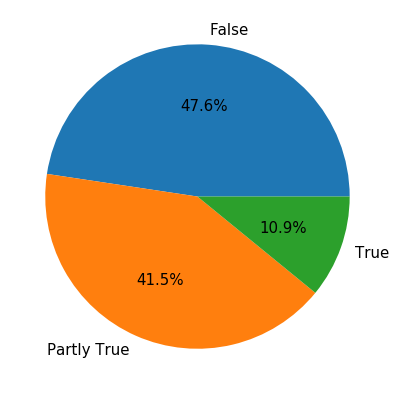

In [6]:
#Plotting a Pie chart for the no. of False, Partly True and True labels
labels = 'False', 'Partly True', 'True'
sizes = [x for x in claims_pd['label'].value_counts()]

plt.figure(figsize=(10,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 15})

plt.show()

**The pie chart represents how varied the portion of false, partly true and true claims in the dataset is. We can observe that there is only 10% of true claims while there is about 50% of false claims**

**Let's explore further**

In [7]:
#Counting the frequency of unique values in the claimant column
claims_pd['claimant'].value_counts()[1:6]

Donald Trump       1233
Bloggers            372
Barack Obama        234
Hillary Clinton     220
Viral image         127
Name: claimant, dtype: int64

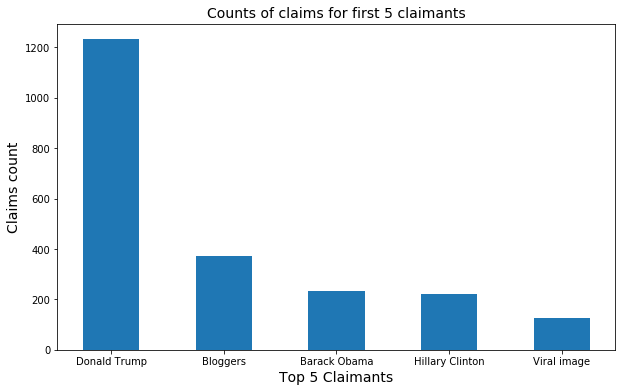

In [8]:
#Plotting a bar graph for count of the claims for the first 5 claimants
plt.figure(figsize=(10,6))
label = ['Donald Trump', 'Bloggers', 'Barack Obama', 'Hillary Clinton', 'Viral image']

data = [claims_pd['claimant'].value_counts()[1:6][i] for i in range(5)]
plt.bar(label, height = data, width = 0.5)
#Setting the title
plt.title('Counts of claims for first 5 claimants', fontsize=14)
#Setting the x-label
plt.xlabel('Top 5 Claimants',fontsize=14)
#Seting the y-label
plt.ylabel('Claims count',fontsize=14)

plt.show()

**The plot above represents the top 5 counts of claims made by the claimants. Out of them Donald Trump had the highest number of claims made**

**We will divide this further**

In [9]:
#Putting the top five claimants in a list
top5 = claims_pd[(claims_pd['claimant'] == 'Donald Trump') | (claims_pd['claimant'] == 'Bloggers') | (claims_pd['claimant'] == 'Barack Obama') | (claims_pd['claimant'] =='Hillary Clinton') | (claims_pd['claimant'] =='Viral image')]
top5['label_new'] = top5['label'].map({0: 'False', 1:'Partly True', 2: 'True'})

C:\Users\Siddhant.Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


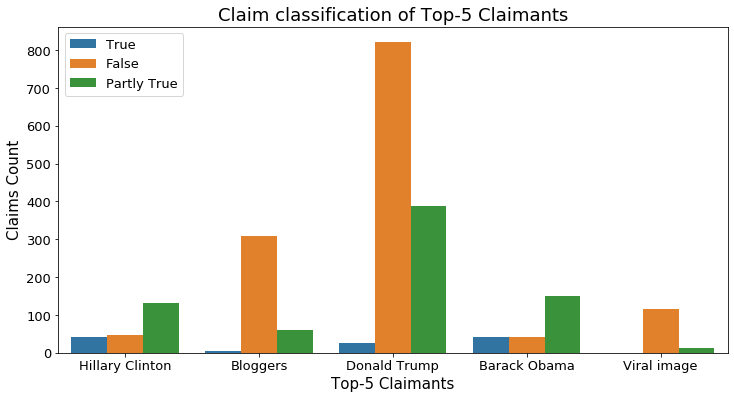

In [10]:
#Plotting a histogram of for the top 5 claimants and the validity of their claim
plt.figure(figsize=(12,6))
sns.countplot(x='claimant',data=top5,hue='label_new')
#Setting the title
plt.title('Claim classification of Top-5 Claimants', fontsize=18)
#Setting the x-label
plt.xlabel('Top-5 Claimants',fontsize=15)
plt.xticks(fontsize=13)
#Setting the y-label
plt.ylabel('Claims Count',fontsize=15)
plt.yticks(fontsize=13)

plt.legend(fontsize=13)

plt.show()

**The above plot represents the distribution of number of false, partly true and true claims made by the top 5 claimants**

**Out of the top 5 only Barack Obama and Hilary Clinton made true claims more than the false or partly true claims**

**Also it is astonishing to note that Donald Trump made more false claims than 50% of the his total claims**

## Data Cleaning

### a) Cleaning Articles

**Extracting the articles from the system and merging the articles for the respective claims below. Then, performing text cleaning on the merged article for each claim, removing stopwords, converting the letters to small case, and stemming the words**

In [11]:
# Defining a new function to concatenate and clean the articles

def new_data(ind):
    concat_article = []
    for i in range(len(claims_pd.iloc[ind, -1])):
        article_number = claims_pd.iloc[ind, -1][i]
        with open(os.path.join(ARTICLES_FILEPATH, '%d.txt' % article_number), 'r', encoding="utf8") as f:
            a = f.read()
        concat_article.append(a)
    new = []
    for a in range(len(concat_article)):
        sp = concat_article[a].split('\n')
        new.append(sp)
    
    sentences = sent_tokenize(str(new))
    tokens = re.split(r'\W+', str(sentences))
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    
    stemmatizer = SnowballStemmer('english')
    stemmatized = [stemmatizer.stem(word) for word in words]
    return(stemmatized)

In [12]:
#Applying the above function to our dataframe
clean_articles = [str(new_data(i)) for i in range(len(claims_pd))]

In [13]:
#Checking for the type of our cleaned data
type(clean_articles)

list

### b) Cleaning Claims

The process for text cleaning is the same as that of articles.

In [14]:
# Defining a function to clean the claims

def clean_claim(ind):
    
    sentences = sent_tokenize(str(claims_pd.iloc[ind, 0]))
    tokens = re.split(r'\W+',str(sentences))
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    stemmatizer = SnowballStemmer('english')
    stemmatized = [stemmatizer.stem(word) for word in words]
    return(stemmatized)

In [15]:
#Applying the above function to our dataframe
clean_claims = [str(clean_claim(i)) for i in range(len(claims_pd))]

In [16]:
#Displaying our cleaned claims
clean_claims

["['line', 'georg', 'orwel', 'novel', 'predict', 'power', 'smartphon']",
 "['main', 'legislatur', 'candid', 'lesli', 'gibson', 'insult', 'parkland', 'shoot', 'survivor', 'activist', 'emma', 'gonzalez', 'via', 'twitter']",
 "['year', 'old', 'girl', 'name', 'alyssa', 'carson', 'train', 'nasa', 'becom', 'astronaut']",
 "['author', 'roald', 'dahl', 'pen', 'open', 'letter', 'urg', 'parent', 'children', 'vaccin', 'measl']",
 "['come', 'fight', 'terror', 'anoth', 'thing', 'know', 'work', 'base', 'lot', 'empir', 'evid', 'tortur']",
 "['rhode', 'island', 'almost', 'dead', 'last', 'among', 'northeastern', 'state', 'length', 'time', 'first', 'degre', 'murder', 'must', 'spend', 'prison', 'elig', 'parol']",
 "['poorest', 'counti', 'u', 'appalachia', 'happen', 'percent', 'white']",
 "['koch', 'industri', 'paid', 'legal', 'fee', 'georg', 'zimmerman']",
 "['minnesota', 'michigan', 'iowa', 'alreadi', 'mph', 'speed', 'limit', 'rural', 'interst', 'see', 'abl', 'safe']",
 "['fbi', 'uniform', 'crime', 'rep

### c) Appending cleaned articles and claims in the claims_pd dataframe.

In [17]:
#Adding our cleaned claims and cleaned articles to the orignal dataframe
claims_pd['clean articles'] = clean_articles
claims_pd['clean claims'] = clean_claims

claims_pd #Displaying the appended dataframe

,claim,claimant,date,id,label,related_articles,clean articles,clean claims
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","['georg', 'orwel', 'predict', 'almost', 'year'...","['line', 'georg', 'orwel', 'novel', 'predict',..."
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","['republican', 'critic', 'parkland', 'student'...","['main', 'legislatur', 'candid', 'lesli', 'gib..."
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","['first', 'person', 'complet', 'nasa', 'passpo...","['year', 'old', 'girl', 'name', 'alyssa', 'car..."
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","['danger', 'measl', 'tweet', 'march', 'mani', ...","['author', 'roald', 'dahl', 'pen', 'open', 'le..."
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","['remark', 'counterterror', 'stanford', 'unive...","['come', 'fight', 'terror', 'anoth', 'thing', ..."
5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,7,2,"[8284, 3768, 20091, 82368, 73148, 4493]","['lis', 'code', 'virginia', 'prev', 'next', 'p...","['rhode', 'island', 'almost', 'dead', 'last', ..."
6,The poorest counties in the U.S. are in Appala...,Jim Webb,2014-11-19,8,1,"[70709, 70708]","['counti', 'appalachia', 'alabama', 'bibb', 'b...","['poorest', 'counti', 'u', 'appalachia', 'happ..."
7,Koch Industries paid the legal fees of George ...,,2013-07-18,9,0,"[120591, 120592, 127866, 129483]","['updat', 'confront', 'fals', 'alleg', 'georg'...","['koch', 'industri', 'paid', 'legal', 'fee', '..."
8,"""Minnesota, Michigan, Iowa already have 70 mph...",Robin Vos,2013-08-22,11,1,"[69547, 80095, 7994, 81116, 77621]","['robin', 'vos', 'discuss', 'milwauke', 'crime...","['minnesota', 'michigan', 'iowa', 'alreadi', '..."
9,"""FBI Uniform Crime Report for 2016 shows more ...",Nick Schroer,2017-10-17,12,1,"[72012, 26005, 43481, 55671]","['fbi', 'four', 'time', 'peopl', 'stab', 'deat...","['fbi', 'uniform', 'crime', 'report', 'show', ..."


**A column is added with the Year of the claim below**

In [18]:
#Adding a new column showing the year for the made claim
claims_pd['year'] = [int(claims_pd['date'][i][0:4]) for i in claims_pd.index]
#Adding a new column showing the validity(label) for the made claim
claims_pd['label_new'] = claims_pd['label'].map({0: 'False', 1:'Partly True', 2: 'True'})

claims_pd #Displaying the claim

,claim,claimant,date,id,label,related_articles,clean articles,clean claims,year,label_new
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","['georg', 'orwel', 'predict', 'almost', 'year'...","['line', 'georg', 'orwel', 'novel', 'predict',...",2017,False
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","['republican', 'critic', 'parkland', 'student'...","['main', 'legislatur', 'candid', 'lesli', 'gib...",2018,True
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","['first', 'person', 'complet', 'nasa', 'passpo...","['year', 'old', 'girl', 'name', 'alyssa', 'car...",2018,Partly True
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","['danger', 'measl', 'tweet', 'march', 'mani', ...","['author', 'roald', 'dahl', 'pen', 'open', 'le...",2019,True
4,"When it comes to fighting terrorism, ""Another ...",Hillary Clinton,2016-03-22,6,2,"[41099, 89899, 72543, 82644, 95344, 88361]","['remark', 'counterterror', 'stanford', 'unive...","['come', 'fight', 'terror', 'anoth', 'thing', ...",2016,True
5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,7,2,"[8284, 3768, 20091, 82368, 73148, 4493]","['lis', 'code', 'virginia', 'prev', 'next', 'p...","['rhode', 'island', 'almost', 'dead', 'last', ...",2014,True
6,The poorest counties in the U.S. are in Appala...,Jim Webb,2014-11-19,8,1,"[70709, 70708]","['counti', 'appalachia', 'alabama', 'bibb', 'b...","['poorest', 'counti', 'u', 'appalachia', 'happ...",2014,Partly True
7,Koch Industries paid the legal fees of George ...,,2013-07-18,9,0,"[120591, 120592, 127866, 129483]","['updat', 'confront', 'fals', 'alleg', 'georg'...","['koch', 'industri', 'paid', 'legal', 'fee', '...",2013,False
8,"""Minnesota, Michigan, Iowa already have 70 mph...",Robin Vos,2013-08-22,11,1,"[69547, 80095, 7994, 81116, 77621]","['robin', 'vos', 'discuss', 'milwauke', 'crime...","['minnesota', 'michigan', 'iowa', 'alreadi', '...",2013,Partly True
9,"""FBI Uniform Crime Report for 2016 shows more ...",Nick Schroer,2017-10-17,12,1,"[72012, 26005, 43481, 55671]","['fbi', 'four', 'time', 'peopl', 'stab', 'deat...","['fbi', 'uniform', 'crime', 'report', 'show', ...",2017,Partly True


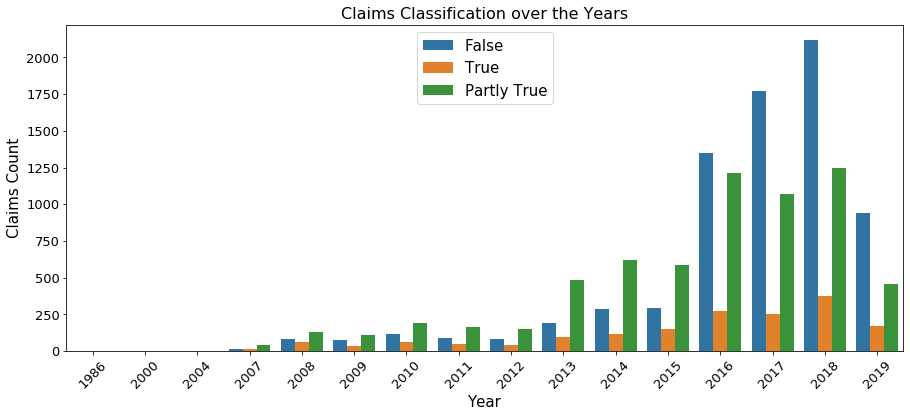

In [19]:
#Plotting a histogram for the no of claims over the years and their label
plt.figure(figsize=(15,6))
sns.countplot(x='year',data=claims_pd,hue='label_new')
#Setting the title
plt.title('Claims Classification over the Years', fontsize=16)
#Setting the x-label
plt.xlabel('Year',fontsize=15)
plt.xticks(fontsize=13, rotation = 45)
#Setting the y-label
plt.ylabel('Claims Count',fontsize=15)
plt.yticks(fontsize=13)

plt.legend(fontsize=15)

plt.show()

The plot depicts the bifurcation of claims made each year. As we can see the number of claims made kept on increasing until 2018 and along with it the count of false claims also kept on increasing each year.

**Note: As there isn't much data for 2019 in our dataset, a low count is observed which should not be confused with low count of claims made actually in that year**

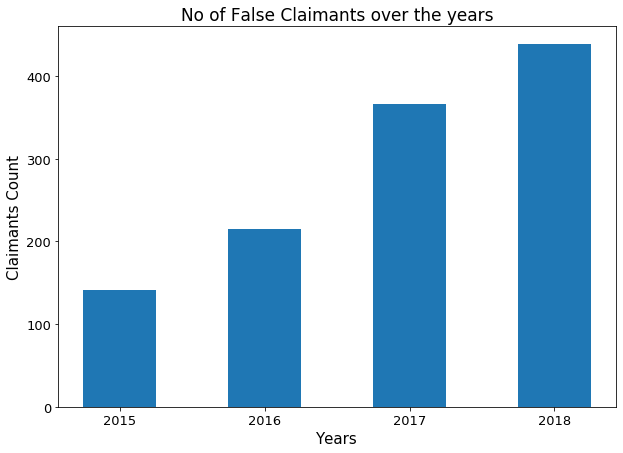

In [20]:
#Plotting a bar chart for the no. of false claimants over the years
fc = claims_pd[claims_pd['label']==0].groupby(['year'])['claimant'].nunique()[9:13]
label = ['2015', '2016', '2017', '2018']
plt.figure(figsize=(10,7))
plt.bar(label, height = fc, width = 0.5)

#Setting the title
plt.title('No of False Claimants over the years', fontsize=17)
#Setting the x-label
plt.xlabel('Years',fontsize=15)
plt.xticks(fontsize=13)
#Seting the y-label
plt.ylabel('Claimants Count',fontsize=15)
plt.yticks(fontsize=13)

plt.show()

The bar-chart shows how the number of false claimants have increased year-on-year since 2015 to 2018

**For the model, we will omit the claims made by Donald Trump, Hillary Clinton and Barack Obama and then make predictions on these omitted datapoints**

**Splitting the dataset below**

In [21]:
big = claims_pd[~ ((claims_pd['claimant']=='Donald Trump') | (claims_pd['claimant']=='Hillary Clinton') | (claims_pd['claimant']=='Barack Obama'))] 
# Training data set without taking Donald Trump, Hillary Clinton and Barack Obama in the data set

small = claims_pd[(claims_pd['claimant']=='Donald Trump') | (claims_pd['claimant']=='Hillary Clinton') | (claims_pd['claimant']=='Barack Obama')] 
# Testing data set with Donald Trump, Hillary Clinton and Barack Obama in the data set

In [22]:
big  #Displaying the training dataset

,claim,claimant,date,id,label,related_articles,clean articles,clean claims,year,label_new
0,A line from George Orwell's novel 1984 predict...,,2017-07-17,0,0,"[122094, 122580, 130685, 134765]","['georg', 'orwel', 'predict', 'almost', 'year'...","['line', 'georg', 'orwel', 'novel', 'predict',...",2017,False
1,Maine legislature candidate Leslie Gibson insu...,,2018-03-17,1,2,"[106868, 127320, 128060]","['republican', 'critic', 'parkland', 'student'...","['main', 'legislatur', 'candid', 'lesli', 'gib...",2018,True
2,A 17-year-old girl named Alyssa Carson is bein...,,2018-07-18,4,1,"[132130, 132132, 149722]","['first', 'person', 'complet', 'nasa', 'passpo...","['year', 'old', 'girl', 'name', 'alyssa', 'car...",2018,Partly True
3,In 1988 author Roald Dahl penned an open lette...,,2019-02-04,5,2,"[123254, 123418, 127464]","['danger', 'measl', 'tweet', 'march', 'mani', ...","['author', 'roald', 'dahl', 'pen', 'open', 'le...",2019,True
5,"Rhode Island is ""almost dead last"" among North...",Leonidas Raptakis,2014-02-11,7,2,"[8284, 3768, 20091, 82368, 73148, 4493]","['lis', 'code', 'virginia', 'prev', 'next', 'p...","['rhode', 'island', 'almost', 'dead', 'last', ...",2014,True
6,The poorest counties in the U.S. are in Appala...,Jim Webb,2014-11-19,8,1,"[70709, 70708]","['counti', 'appalachia', 'alabama', 'bibb', 'b...","['poorest', 'counti', 'u', 'appalachia', 'happ...",2014,Partly True
7,Koch Industries paid the legal fees of George ...,,2013-07-18,9,0,"[120591, 120592, 127866, 129483]","['updat', 'confront', 'fals', 'alleg', 'georg'...","['koch', 'industri', 'paid', 'legal', 'fee', '...",2013,False
8,"""Minnesota, Michigan, Iowa already have 70 mph...",Robin Vos,2013-08-22,11,1,"[69547, 80095, 7994, 81116, 77621]","['robin', 'vos', 'discuss', 'milwauke', 'crime...","['minnesota', 'michigan', 'iowa', 'alreadi', '...",2013,Partly True
9,"""FBI Uniform Crime Report for 2016 shows more ...",Nick Schroer,2017-10-17,12,1,"[72012, 26005, 43481, 55671]","['fbi', 'four', 'time', 'peopl', 'stab', 'deat...","['fbi', 'uniform', 'crime', 'report', 'show', ...",2017,Partly True
10,"""Pelosi Sinks to New Low, Tells Dems: If You ...",Western Journal,2018-08-21,13,0,"[27062, 27061, 20679, 61872, 20677]","['pelosi', 'sink', 'new', 'low', 'tell', 'dem'...","['pelosi', 'sink', 'new', 'low', 'tell', 'dem'...",2018,False


## Model Preparation

**As the datasets are ready now, dataset is vecorized using TF-IDF and the model implementation is done**

Using TF-IDF vectorizer for converting the text to vectors.

Term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

Source - https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### a) Vectorizing training dataset

In [23]:
#Using the Tfidf Vectorizer on the training set

vectorizer1 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2', max_features = 1400)
array_TFIDF1 = vectorizer1.fit_transform(big['clean claims']+big['clean articles'])
print( len(vectorizer1.get_feature_names() ))
print( array_TFIDF1 )

1400
  (0, 734)	0.09285903542952569
  (0, 547)	0.34439187047124087
  (0, 952)	0.14387113168548726
  (0, 949)	0.03229036304588466
  (0, 52)	0.06693872433786442
  (0, 1395)	0.12040930777566704
  (0, 40)	0.10363045526482537
  (0, 85)	0.03620152263174105
  (0, 1260)	0.13758531156563775
  (0, 1263)	0.0358366566433196
  (0, 1194)	0.027586725088388334
  (0, 480)	0.07137458679878911
  (0, 750)	0.12338430842616703
  (0, 141)	0.2362524845865656
  (0, 59)	0.1042633021278423
  (0, 1356)	0.22866937748914387
  (0, 1138)	0.057029574385362325
  (0, 1386)	0.25975835248482393
  (0, 563)	0.10308212582992043
  (0, 685)	0.029227855587562995
  (0, 470)	0.043967764666533925
  (0, 220)	0.037374750571963045
  (0, 819)	0.025744849409323943
  (0, 1190)	0.13597037830006223
  (0, 617)	0.04755429586903207
  :	:
  (13867, 1385)	0.010202683711726748
  (13867, 1218)	0.03278746150902685
  (13867, 396)	0.0356078589602068
  (13867, 1029)	0.05133885306892756
  (13867, 901)	0.011315532506091212
  (13867, 89)	0.013364578582

### b) Vectorizing testing dataset

In [24]:
#Using the Tfidf Vectorizer on the test set

vectorizer1 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2', max_features = 1400)
array_TFIDF2 = vectorizer1.fit_transform(small['clean claims']+small['clean articles'])
print( len(vectorizer1.get_feature_names() ))
print( array_TFIDF2 )

1400
  (0, 236)	0.01869746262035027
  (0, 483)	0.04538132149227002
  (0, 1249)	0.08001545607251265
  (0, 68)	0.04773528010703185
  (0, 1254)	0.03708181732597013
  (0, 682)	0.050848147922990805
  (0, 1380)	0.13694622640846615
  (0, 125)	0.023411989648861507
  (0, 736)	0.02658034194666213
  (0, 439)	0.06457111937895534
  (0, 1052)	0.0101446649353162
  (0, 1313)	0.03747721556439721
  (0, 1207)	0.023550423093321646
  (0, 61)	0.08742485528000545
  (0, 828)	0.07881132256682936
  (0, 1210)	0.03231867058207867
  (0, 702)	0.05237824267782957
  (0, 1340)	0.018082603189246604
  (0, 1371)	0.015440226608937568
  (0, 1250)	0.16654919670923304
  (0, 102)	0.11240103937172416
  (0, 580)	0.00534771612435557
  (0, 223)	0.009593118318819491
  (0, 1267)	0.10322260688999117
  (0, 819)	0.049034735993817545
  :	:
  (1686, 330)	0.004532052475382043
  (1686, 998)	0.007892678120656596
  (1686, 616)	0.004606005995956869
  (1686, 404)	0.08950444103774492
  (1686, 444)	0.004525435633518348
  (1686, 793)	0.022463691

In [25]:
#Allocating the training and testing datasets

X_train = array_TFIDF1
X_test = array_TFIDF2
y_train = big['label']
y_test = small['label']

## Model Implementation

**Let's implement algorithms on the training dataset**

**a) Random Forest**

In [26]:
#Using the Random Forest Algorithm
rf = RandomForestClassifier(random_state = 0)
#Fitting the model
rf.fit(X_train, y_train)
predictions0 = rf.predict(X_test)
#Finding the accuracy of the predictions
ACCU = accuracy_score(y_test, predictions0)
print('Accuracy:', ACCU)
#Printing the classification report 
print(classification_report(y_test,predictions0))

C:\Users\Siddhant.Agarwal\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.43864848844101956
              precision    recall  f1-score   support

           0       0.51      0.55      0.53       910
           1       0.36      0.35      0.36       669
           2       0.03      0.01      0.01       108

    accuracy                           0.44      1687
   macro avg       0.30      0.31      0.30      1687
weighted avg       0.42      0.44      0.43      1687



**b) XGBoost**

In [27]:
xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
ACCU = accuracy_score(y_test, predictions)
print('Accuracy:', round(ACCU,2))
print(classification_report(y_test,predictions))

Accuracy: 0.44
              precision    recall  f1-score   support

           0       0.50      0.60      0.54       910
           1       0.35      0.31      0.33       669
           2       1.00      0.01      0.02       108

    accuracy                           0.44      1687
   macro avg       0.61      0.30      0.30      1687
weighted avg       0.47      0.44      0.42      1687



**c) Support Vector Machines (SVM)**

In [28]:
#Using SVM ( Linear ) model
svcl = LinearSVC(random_state = 0)
#Fitting the model
svcl.fit(X_train, y_train)
predictions2 = svcl.predict(X_test)
#Finding the accuracy of the predictions
ACCU = accuracy_score(y_test, predictions2)
print('Accuracy:', ACCU)
#Printing the classification report 
print(classification_report(y_test,predictions2))

Accuracy: 0.38648488441019563
              precision    recall  f1-score   support

           0       0.45      0.22      0.30       910
           1       0.37      0.67      0.47       669
           2       0.00      0.00      0.00       108

    accuracy                           0.39      1687
   macro avg       0.27      0.30      0.26      1687
weighted avg       0.39      0.39      0.35      1687



**d) Logistic Regression**

In [29]:
#Using Logistic Regression
model_LR = LogisticRegression()
model_LR.fit(X_train,y_train)
predictions3 = model_LR.predict(X_test)
#Finding the accuracy of the predictions
ACCUs = accuracy_score(y_test, predictions3)
print('Accuracy:', ACCUs)
#Printing the classification report 
print(classification_report(y_test,predictions3))

C:\Users\Siddhant.Agarwal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Siddhant.Agarwal\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.3935981031416716
              precision    recall  f1-score   support

           0       0.45      0.26      0.33       910
           1       0.37      0.64      0.47       669
           2       0.00      0.00      0.00       108

    accuracy                           0.39      1687
   macro avg       0.27      0.30      0.27      1687
weighted avg       0.39      0.39      0.36      1687



C:\Users\Siddhant.Agarwal\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Out of the models implemented, XGBoost performs best as it gave the best combination of accuracy and macro F1 score. Therefore, selecting this model for further analysis**

## Discussions on model

**Plotting to make inferences from our model and discuss the viability**

In [30]:
#Converting our y_test list to a dataframe
x = pd.DataFrame(y_test)

#Defining new columns
x['predictions'] = predictions
x['Year'] = small['year']
x['claimant'] = small['claimant']
x['label_new'] = x['label'].map({0: 'False', 1:'Partly True', 2: 'True'})
x['Prediction Class']=['Correct' if x['label'][i]==x['predictions'][i] else 'Incorrect' for i in x.index]

#Counting the no. of Correct and Incorrect predictions
x['Prediction Class'].value_counts()

Incorrect    938
Correct      749
Name: Prediction Class, dtype: int64

**a) Plotting to see how good our model worked**

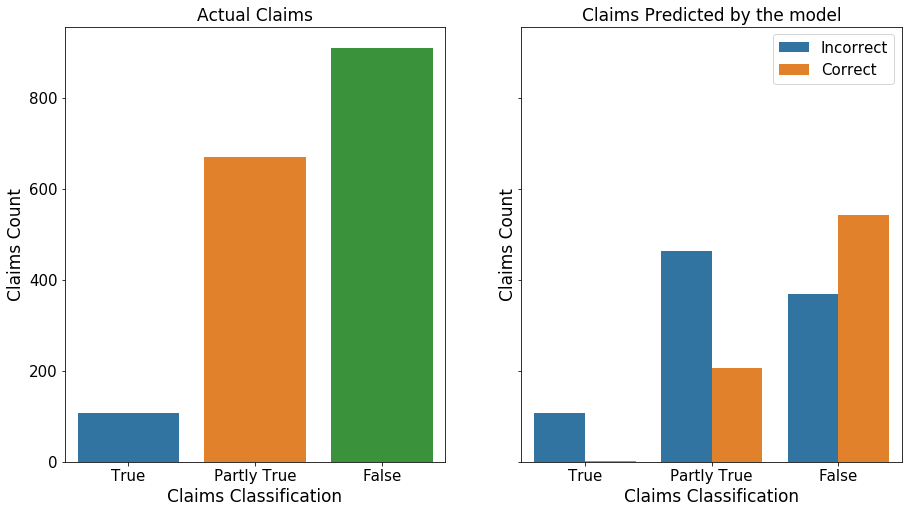

In [31]:
#Plotting a bar graph for the validity(label) of the actual claims
fig, p=plt.subplots(nrows=1, ncols=2, figsize=(15,8), sharey = True)
sns.countplot(x='label_new',data=x,ax=p[0])
#Setting the title
p[0].set_title('Actual Claims', fontsize = 17)
#Setting the x-label
p[0].set_xlabel('Claims Classification', fontsize = 17)
#Setting the y-label
p[0].set_ylabel('Claims Count', fontsize = 17)
p[0].tick_params(axis='both', which='major', labelsize=15)

#Plotting a bargraph for the predicted claims and their accuracy
sns.countplot(x='label_new',data=x,hue='Prediction Class',ax=p[1])
#Setting the title
p[1].set_title('Claims Predicted by the model', fontsize = 17)
#Setting the x-label
p[1].set_xlabel('Claims Classification', fontsize = 17)
#Setting the y-label
p[1].set_ylabel('Claims Count', fontsize = 17)
p[1].tick_params(axis='both', which='major', labelsize=15)
p[1].legend(fontsize=15)

plt.show()

**From the plot it can be inferred that the model correctly predicted the false claims better than the others as the data for false claims is more as compared to that of the true or partly true claims**

**And with more/equivalent number of datapoints for the other two categories, our model can predict classes more accurately**

**b) Plotting for count of claims distributed over the years**

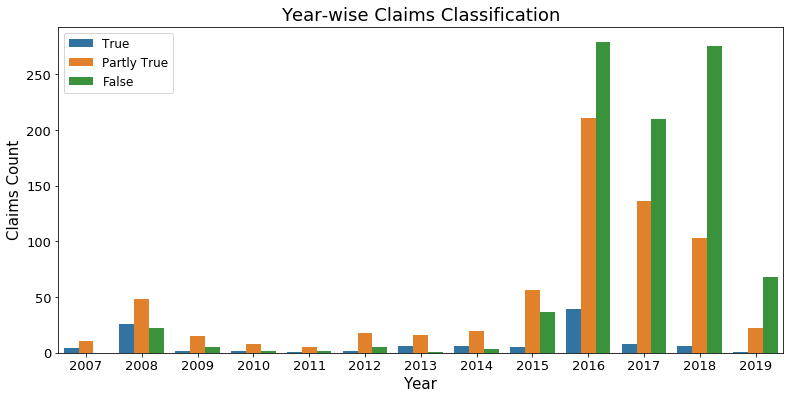

In [32]:
plt.figure(figsize=(13,6))
#Plotting a graph for no of claims made by Donald Trump over the years and their validity(label)
sns.countplot(x='Year',data=x,hue='label_new')
#Setting the title
plt.title('Year-wise Claims Classification', fontsize=18)
plt.legend(loc = 2, fontsize=12)
#Setting the x-label
plt.xlabel('Year',fontsize=15)
plt.xticks(fontsize=13)
#Setting the y-label
plt.ylabel('Claims Count',fontsize=15)
plt.yticks(fontsize=13)
#Displaying the graph
plt.show()

**The plot shows the collective number of false, partly true, true claims made by Donald Trump, Hillary Clinton and Barack Obama each year. It can be inferred that collectively they made mostly false claims and the peak was around the time of USA 2016 elections**

**Let's explore further on the Correct Predictions of our testing dataset**

**a) Plotting distribution of claims for the three politicians**

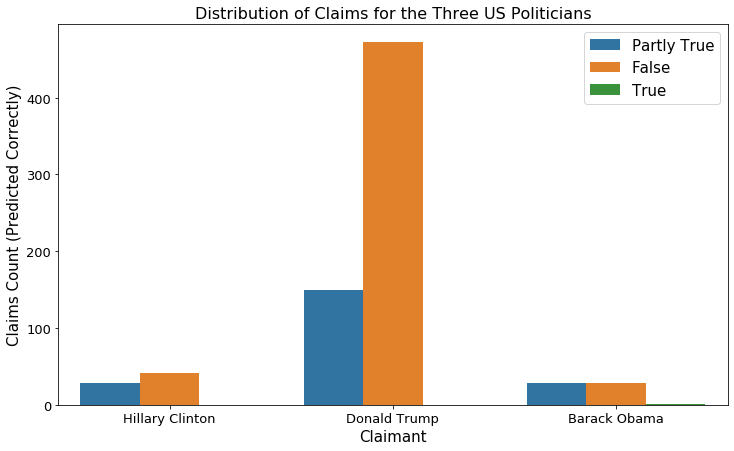

In [33]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x="claimant", data=x[x['Prediction Class']=='Correct'], hue='label_new')
plt.xlabel('Claimant',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Claims Count (Predicted Correctly)',fontsize=15)
plt.yticks(fontsize=13)
plt.title("Distribution of Claims for the Three US Politicians", fontsize=16)
plt.legend(fontsize=15)
plt.show()

**The model has correctly predicted the above count of claims made by the politicians**

**It can be observed that the highest count is of false claims made by Donald Trump**

**b) Plotting distribution of false claims made by Donald Trump over the years**

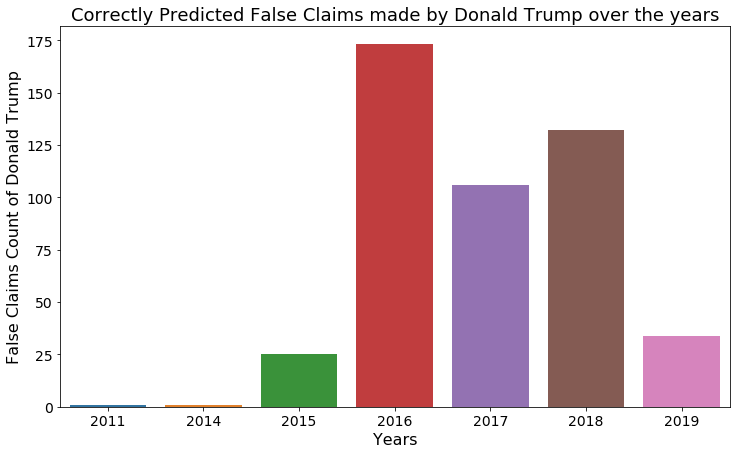

In [34]:
plt.figure(figsize=(12,7))
ax = sns.countplot(x="Year", data=x[(x['Prediction Class']=='Correct') & (x['claimant']=='Donald Trump') & (x['label_new']=='False')])
plt.xlabel('Years',fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('False Claims Count of Donald Trump',fontsize=16)
plt.yticks(fontsize=14)
plt.title("Correctly Predicted False Claims made by Donald Trump over the years", fontsize=18)
plt.show()

**It can be inferred that the count of false claims by Donald Trump increased exponentially until 2016 after which he came to power. Even after coming to power, he carried out the same philosophy and kept on making false claims**

**This shows that since his ideology of making false claims worked for the better for him during the elections, he didn't stop it and relied on the same to influence the American society**

**Here are some of the examples of false claims made by Donald Trump after he became President. These claims were correctly predicted by the model as false**

In [35]:
print ("The claim made - ",claims_pd.loc[3445].claim, "\n\nDetails of the claim -\n",x.loc[3445])

The claim made -   “In fact the GDP since I’ve taken over has doubled and tripled.”  

Details of the claim -
 label                          0
predictions                    1
Year                        2018
claimant            Donald Trump
label_new                  False
Prediction Class       Incorrect
Name: 3445, dtype: object


#### This is a wild exaggeration. U.S. gross domestic product grew by 2.3 per cent in 2017. It grew by 2 per cent in the first quarter of 2018.

Source: https://projects.thestar.com/donald-trump-fact-check/

In [36]:
print ("The claim made - ",claims_pd.loc[7825].claim, "\n\nDetails of the claim -\n", x.loc[7825])

The claim made -   "I don’t know if you noticed, but deficits seem to be coming down."  

Details of the claim -
 label                          0
predictions                    0
Year                        2019
claimant            Donald Trump
label_new                  False
Prediction Class         Correct
Name: 7825, dtype: object


#### In fact, the deficit in the first three months of fiscal year 2019 was 42 percent higher than it was for the same period last year.

Source: https://www.factcheck.org/2019/02/trump-disinformation-on-deficits/

In [37]:
print ("The claim made - ",claims_pd.loc[2711].claim, "\n\nDetails of the claim -\n", x.loc[2711])

The claim made -   "Dishonestly called 'Medicare for All,' the Democratic proposal ... would cost an astonishing $32.6 trillion during its first 10 years."  

Details of the claim -
 label                          0
predictions                    0
Year                        2018
claimant            Donald Trump
label_new                  False
Prediction Class         Correct
Name: 2711, dtype: object


#### That’s an estimate of the cost to the federal government, but that ignores the offsetting savings in health care costs for individuals, employers and state governments. 

Source: https://www.factcheck.org/2018/10/factchecking-trumps-medicare-op-ed/

In [38]:
print ("The claim made - ",claims_pd.loc[11509].claim, "\n\nDetails of the claim -\n", x.loc[11509])

The claim made -  "The noise (from windmills) causes cancer." 

Details of the claim -
 label                          0
predictions                    0
Year                        2019
claimant            Donald Trump
label_new                  False
Prediction Class         Correct
Name: 11509, dtype: object


#### There is no good evidence that the noise from wind turbines causes cancer. (Some people have indeed alleged that turbines cause all sorts of ailments, so Trump was not wrong when he said "they say," but the underlying assertion is false.)

Source: https://projects.thestar.com/donald-trump-fact-check/

In [39]:
print ("The claim made -",claims_pd.loc[9879].claim)

The claim made -  "The GDP Rate (4.2%) is higher than the Unemployment Rate (3.9%) for the first time in over 100 years!" 


#### By analyzing M. Trump’s comparison of a quarterly data (GDP growth at an annual rate) with a monthly data (unemployment rate), we can see that his statement is still false, as shown by this AFP chart based on data by the Bureau of Economic Analysis and the Bureau of Labor Statistics, two reference institutions on employment and the economy.

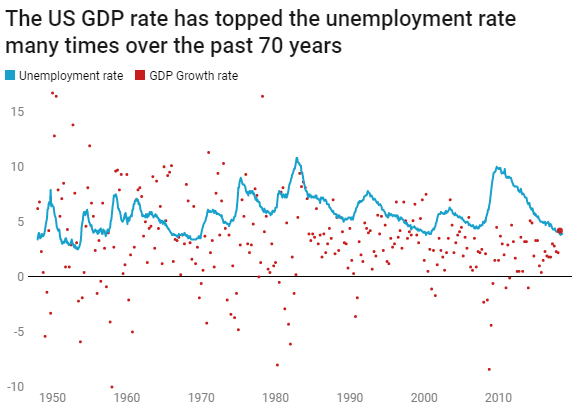

Source: https://factcheck.afp.com/no-us-economic-growth-not-overtaking-unemployment-first-time-century

**c) Plotting confusion matrix heatmap of our model**

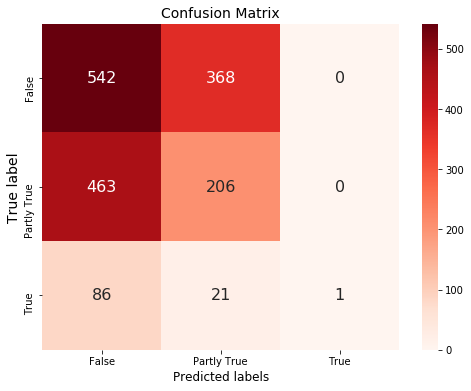

In [40]:
#https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/48018785
#Plotting a confusion matrix for the Actual vs Predicted labels
plt.figure(figsize=(8,6))
labels = ['False', 'Partly True', 'True']
cm = confusion_matrix(y_test, predictions)
ax= plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g',cmap='Reds') #annot=True to annotate cells
#Setting the x-label
ax.set_xlabel('Predicted labels',fontsize=12)
#Setting the y-label
ax.set_ylabel('True label',fontsize=14)
#Setting the title
ax.set_title('Confusion Matrix',fontsize=14) 
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
#Displaying the matrix
plt.show()

**From the confusion matrix heatmap, we can determine that our model works quite good for False claims. This emphasizes the need of more datapoints for the other two categories to build a model upon**

## Code for Competition

The part till the cleaning of the articles and claims is the same what is done in project. After text cleaning we performed cosine similarity on the cleaned claims and articles, split the model for training and testing and implemented various models to get the best accuracy and macro F1 score. But here I will only show SVM model as it performed the best among all the models tried.

### Vectorizing claims

In [41]:
#Using the Tfidf Vectorizer on the claims set

vectorizer1 = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2')
array_TFIDF1 = vectorizer1.fit_transform(clean_claims)
print( len(vectorizer1.get_feature_names() ))
print( array_TFIDF1 )

14190
  (0, 7033)	0.30072992922638997
  (0, 4874)	0.28083967209141697
  (0, 8981)	0.46865524569055234
  (0, 8612)	0.46865524569055234
  (0, 9793)	0.35253502618504445
  (0, 9754)	0.29108022508315096
  (0, 11542)	0.42709070172363184
  (1, 7286)	0.2573606181140653
  (1, 6894)	0.2584118234498761
  (1, 1751)	0.193258047141338
  (1, 6935)	0.3611555990864486
  (1, 4908)	0.32792719093601713
  (1, 6085)	0.29617915342369
  (1, 9216)	0.2695624623768247
  (1, 11340)	0.20069276259603896
  (1, 12194)	0.27104283301492915
  (1, 106)	0.2584118234498761
  (1, 3895)	0.3027908705272563
  (1, 5013)	0.32792719093601713
  (1, 13543)	0.1386159734238779
  (1, 13108)	0.17981416213495077
  (2, 14082)	0.16484898145322877
  (2, 8870)	0.25626983559328115
  (2, 4932)	0.27654614327242977
  (2, 8136)	0.25352470717264547
  :	:
  (15552, 13748)	0.428209863086624
  (15552, 6119)	0.44257959916344436
  (15553, 2659)	0.2148614783734557
  (15553, 2224)	0.2565246475012018
  (15553, 7613)	0.2255219204175541
  (15553, 104)	0.25

### Vectorizing articles

As the article length is huge thus, we will be reducing the dimensions of the vector for articles for implementation of cosine similarity.

In [42]:
#Using the Tfidf Vectorizer on the articles set

vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2', max_features = 14190)
array_TFIDF = vectorizer.fit_transform(clean_articles)
print( len(vectorizer.get_feature_names() ))
print( array_TFIDF )

14190
  (0, 5121)	0.15074637210734548
  (0, 9764)	0.0485028470268125
  (0, 362)	0.03411318606143734
  (0, 14074)	0.06274074612286677
  (0, 240)	0.05259382583609772
  (0, 618)	0.01854130488862225
  (0, 2529)	0.05354477790977509
  (0, 13908)	0.2493089830432783
  (0, 11627)	0.029289183810400417
  (0, 12624)	0.07050470695907807
  (0, 12641)	0.0183181972126381
  (0, 11953)	0.014151214564385685
  (0, 3398)	0.05109004539998751
  (0, 4444)	0.03624193190214442
  (0, 7407)	0.06266678891527268
  (0, 1233)	0.11960204034563222
  (0, 1589)	0.18920292064560248
  (0, 388)	0.05307308050939248
  (0, 13715)	0.11637080218744242
  (0, 11289)	0.02922339290219494
  (0, 13977)	0.13306781795636496
  (0, 6442)	0.03390958529234547
  (0, 5274)	0.05286244412880378
  (0, 6798)	0.014903170887667292
  (0, 4399)	0.022623277943935375
  :	:
  (15554, 10371)	0.014574124650627893
  (15554, 4216)	0.018229317727865877
  (15554, 14150)	0.013339984500936772
  (15554, 14061)	0.036538766947712464
  (15554, 5441)	0.0152972550152

### Cosine Similarity

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
cos = cosine_similarity(array_TFIDF1, array_TFIDF)

In [45]:
y = claims_pd['label']
X = cos

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

### Model Implementation

#### SVM

In [46]:
svcl = LinearSVC(random_state = 0)
svcl.fit(X_train, y_train)
predictions = svcl.predict(X_test)
ACCU = accuracy_score(y_test, predictions)
print('Accuracy:', ACCU)
print(classification_report(y_test,predictions))

Accuracy: 0.5761731304906792
              precision    recall  f1-score   support

           0       0.60      0.68      0.64      2231
           1       0.56      0.60      0.58      1920
           2       0.24      0.04      0.07       516

    accuracy                           0.58      4667
   macro avg       0.47      0.44      0.43      4667
weighted avg       0.54      0.58      0.55      4667

